In [ ]:
!pip3 install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 4.7 MB 4.9 MB/s 


In [ ]:
!pip install -q tensorflow==2.0.0

In [ ]:
!pip3 install -q scann tensorflow-recommenders

     |████████████████████████████████| 10.4 MB 4.0 MB/s 
     |████████████████████████████████| 89 kB 6.0 MB/s 
     |████████████████████████████████| 578.1 MB 24 kB/s 
     |████████████████████████████████| 5.9 MB 34.2 MB/s 
     |████████████████████████████████| 1.7 MB 45.6 MB/s 
     |████████████████████████████████| 438 kB 58.6 MB/s 


In [ ]:
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import tensorflow as tf

In [ ]:
rating_dataset, rating_dataset_info = tfds.load(
    name='movielens/100k-ratings',
    split='train',
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/movielens/100k-ratings/0.1.1.incompleteSXF1E5/movielens-train.tfrecord*...:   …

Dataset movielens downloaded and prepared to ~/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


In [ ]:
assert isinstance(rating_dataset ,tf.data.Dataset)

In [ ]:
# rating_dataset.__len__()

In [ ]:
# tfds.as_dataframe(rating_dataset.take(5), rating_dataset_info)

In [ ]:
rating_dataset = rating_dataset.map(
    lambda x:{
        'user_id':x['user_id'],
        'movie_id':x['movie_id'],
        'movie_id':x['movie_id'],
        'movie_title':x['movie_title'],
        'timestamp':x['timestamp']
    }
)

# tfds.as_dataframe(
#     rating_dataset.take(5),
#     rating_dataset_info
# )

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
tf.random.set_seed(42)
rating_dataset_shuffled = rating_dataset.shuffle(
    buffer_size=100_000,
    seed=42,
    reshuffle_each_iteration=False
    )

In [ ]:
rating_trainset = rating_dataset_shuffled.take(80_000)
rating_testset = rating_dataset_shuffled.skip(80_000)

In [ ]:
# # numerical_features -> Normalization (Non-trainable layer)
# # exp : timestamp 

# rating_trainset_timestamp_layer = \
# tf.keras.layers.experimental.preprocessing.Normalization(axis=None)

# rating_trainset_timestamp_layer.adapt(
#   rating_trainset.map(
#       lambda x:x['timestamp']
#   )
# )


In [ ]:
# for i in rating_trainset.take(3).as_numpy_iterator():
#   print(i['timestamp'])
#   print(rating_trainset_timestamp_layer(i['timestamp']))

In [ ]:
# Categorical_features -> StringLookup(Non-trainable) + Embedding(Trainable)
# exp : user_id, email_addrs


#user_id
rating_trainset_userid_lookup_layer = \
tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)

rating_trainset_userid_lookup_layer.adapt(
    rating_trainset.map(
        lambda x:x['user_id']
    )
)

rating_trainset_userid_embedding_layer = \
tf.keras.layers.Embedding(
    input_dim = rating_trainset_userid_lookup_layer.vocab_size(),
    output_dim = 32
)

userid_model = tf.keras.Sequential([rating_trainset_userid_lookup_layer, rating_trainset_userid_embedding_layer])


#movie_id
rating_trainset_movieid_lookup_layer = \
tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)

rating_trainset_movieid_lookup_layer.adapt(
    rating_trainset.map(
        lambda x:x['movie_id']
    )
)

rating_trainset_movieid_embedding_layer = \
tf.keras.layers.Embedding(
    input_dim = rating_trainset_movieid_lookup_layer.vocab_size(),
    output_dim = 32
)

movieid_model = tf.keras.Sequential([rating_trainset_movieid_lookup_layer, rating_trainset_movieid_embedding_layer])


In [ ]:
#print(userid_model(['-2','655']))

In [ ]:
# Textual_features -> TextVectorization(Non-trainable) + Embedding(Trainable) + Avg(Trainable)
# exp : movie_title


In [ ]:
# #movie_title

# movie_title_textVectorization_layer = \
# tf.keras.layers.experimental.preprocessing.TextVectorization()

# movie_title_textVectorization_layer.adapt(
#     rating_trainset.map(
#         lambda x:x['movie_title']
#     )
# )

# print(movie_title_textVectorization_layer.get_vocabulary()[:5])

In [ ]:
#print(movie_title_textVectorization_layer('Pulp Fiction (1994)'))

In [ ]:
# movie_title_embedding = \
# tf.keras.layers.Embedding(
#     input_dim = movie_title_textVectorization_layer.vocabulary_size(),
#     output_dim = 32
# )

# movie_title_model = \
# tf.keras.Sequential([
#     movie_title_textVectorization_layer,
#     movie_title_embedding
# ])

# #print(movie_title_model('Pulp Fiction (1994)'))

In [ ]:
# movie_title_model2 = \
# tf.keras.Sequential([
#     movie_title_textVectorization_layer,
#     movie_title_embedding,
#     tf.keras.layers.GlobalAveragePooling1D()
# ])

# # for row in rating_dataset.batch(1).map(lambda x:x['movie_id']).take(1):
# #   print(movie_title_model2(row))

In [ ]:
candidate_model = movieid_model
query_model = userid_model

## Retrival Task

In [ ]:
retrival_rating_train = rating_trainset.map(
    lambda x:{
        'user_id':x['user_id'],
        'movie_id':x['movie_id'],
    }
)

retrival_rating_test = rating_testset.map(
    lambda x:{
        'user_id':x['user_id'],
        'movie_id':x['movie_id'],
    }
)

In [ ]:
movies_dataset, movies_dataset_info = tfds.load(
    name='movielens/100k-movies',
    split='train',
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/movielens/100k-movies/0.1.1.incompleteX63A48/movielens-train.tfrecord*...:   0…

Dataset movielens downloaded and prepared to ~/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.


In [ ]:
corpus = movies_dataset.map(lambda x:x['movie_id'])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
print(type(movies_dataset))
print(type(corpus))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [ ]:
retrieval_task_layer = tfrs.tasks.Retrieval(
    metrics = tfrs.metrics.FactorizedTopK(
    candidates=corpus.batch(128).map(
        candidate_model
    ))
)

In [ ]:
class RetrivalModel(tfrs.models.Model):

  def __init__(self, query_model, candidate_model, retrival_layer):
    super().__init__()
    self.query_model: tf.keras.Model = query_model
    self.candidate_model: tf.keras.Model = candidate_model
    self.retrival_layer: tf.keras.layers.Layer = retrival_layer

  def compute_loss(self, features, training=False) -> tf.Tensor:
    query_embedding = self.query_model(features['user_id'])
    positive_candidate_embedding = self.candidate_model(features['movie_id'])
    loss = self.retrival_layer(query_embedding, positive_candidate_embedding)
    return loss

In [ ]:
movielens_retrieval_model = RetrivalModel(query_model,candidate_model,retrieval_task_layer)

movielens_retrieval_model.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)
)


In [ ]:
retrival_rating_train = retrival_rating_train.shuffle(100_000).batch(8192).cache()

retrival_rating_test = retrival_rating_test.batch(4096).cache()

history = movielens_retrieval_model.fit(
    retrival_rating_train,
    validation_data = retrival_rating_test,
    validation_freq=1,
    epochs = 5
)

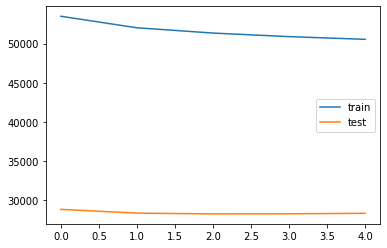

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','test'])
plt.show()

### KNN

In [ ]:
bruteforce_index_layer = \
  tfrs.layers.factorized_top_k.BruteForce(movielens_retrieval_model.query_model)

bruteforce_index_layer.index(
    corpus.batch(100).map(
        movielens_retrieval_model.candidate_model
    ),
    corpus
)


user_id = "42"
scores, movie_ids = bruteforce_index_layer(tf.constante([user_id]))

print(
    movie_ids[0,:5]
)

ValueError: ignored

In [ ]:

# tfds.as_dataframe(
#     movies_dataset.take(5),
#     movies_dataset_info
# )

In [ ]:
# https://github.com/xei/recommender-system-tutorial/blob/main/recommender_system_tutorial.ipynb

In [ ]:
scann_index_layer = \
  tfrs.layers.factorized_top_k.ScaNN(movielens_retrieval_model.query_model)

scann_index_layer.index(
    corpus.batch(100).map(
        movielens_retrieval_model.candidate_model
    ),
    corpus
)


AttributeError: ignored

In [ ]:
user_id = "42"
scores, movie_ids = scann_index_layer(tf.constante([user_id]))

print(
    movie_ids[0,:5]
)